In [1]:
import numpy as np
import pandas as pd
import scipy.io
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline
#import warnings
#warnings.filterwarnings("ignore")
from show_chanWeights import show_chanWeights
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn import metrics

In [2]:
filename1 = "feaSubEImg_1.csv"
filename2 = "feaSubEImg_2.csv"
filename3 = "feaSubEOvert_1.csv"
filename4 = "feaSubEOvert_2.csv"
filename5 = "sensors102.csv"

df_img1       = pd.read_csv(filename1, header = None)
df_img2       = pd.read_csv(filename2, header = None)
df_overt1     = pd.read_csv(filename3, header = None)
df_overt2     = pd.read_csv(filename4, header = None)
df_sensors102 = pd.read_csv(filename5, header = None)

In [3]:
img1       = df_img1.to_numpy()
img2       = df_img2.to_numpy()
overt1     = df_overt1.to_numpy()
overt2     = df_overt2.to_numpy()
sensors102 = df_sensors102.to_numpy()

print(img1.shape)
print(img2.shape)
print(overt1.shape)
print(overt2.shape)
print(sensors102.shape)

(204, 120)
(204, 120)
(204, 120)
(204, 120)
(102, 6)


In [4]:
######################################################################

In [5]:
def find_optimal_reg (accs, reg_type, reg_para) :
    best_i = 0
    best_j = 0 
    best_acc = accs[0, 0]
    for i in range(accs.shape[0]) :
        for j in range(accs.shape[1]) :
            if accs[i, j] > best_acc :
                best_i = i 
                best_j = j 
                best_acc = accs[i, j]
    best_reg_type = reg_type[best_i]
    best_reg_para = reg_para[best_j]
    # return best_i, best_j
    return best_reg_type, best_reg_para

In [6]:
def BCI_Decode (img1, img2) :
    X1 = np.copy(img1.T)
    X2 = np.copy(img2.T)
    y1 = (-1) * np.ones(X1.shape[0])
    y2 = (+1) * np.ones(X2.shape[0])
    cv1 = KFold(n_splits = 6, random_state = None, shuffle = False)
    cv2 = KFold(n_splits = 5, random_state = None, shuffle = False)
    # reg_type = ["l2"]
    # reg_para = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6])
    # reg_type = ["l1", "l2"]
    reg_type = ["l1"]
    reg_para = np.array([1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3])
    cv1_ds = np.zeros((6, 40))
    cv1_acc = np.zeros(7)
    cv1_index = 0 
    #cv1_fold1_weights = np.zeros(X1.shape[1])
    cv1_folds_weights = np.zeros((6, X1.shape[1]))
    
    ###########################################################################################################
    for train_index, test_index in cv1.split(X1) :
        X1_train, X2_train = X1[train_index], X2[train_index]
        X1_test,  X2_test  = X1[test_index],  X2[test_index]
        y1_train, y2_train = y1[train_index], y2[train_index]
        y1_test,  y2_test  = y1[test_index],  y2[test_index]
        
        reg_cv2_acc = np.zeros((len(reg_type), reg_para.shape[0]))
        
        ############################################################################################
        for traincv2, testcv2 in cv2.split(X1_train) :
            X1_train_cv2, X2_train_cv2 = X1_train[traincv2], X2_train[traincv2]
            X1_test_cv2, X2_test_cv2   = X1_train[testcv2], X2_train[testcv2]
            y1_train_cv2, y2_train_cv2 = y1_train[traincv2], y2_train[traincv2]
            y1_test_cv2, y2_test_cv2   = y1_train[testcv2], y2_train[testcv2]
            X_train_cv2 = np.concatenate((X1_train_cv2, X2_train_cv2))
            X_test_cv2  = np.concatenate((X1_test_cv2, X2_test_cv2))
            y_train_cv2 = np.concatenate((y1_train_cv2, y2_train_cv2))
            y_test_cv2  = np.concatenate((y1_test_cv2, y1_test_cv2))
            
            for i in range(len(reg_type)) :
                for j in range(reg_para.shape[0]) :
                    svm_cv2 = LinearSVC(penalty = reg_type[i], C = reg_para[j], dual = False, max_iter = 100000, tol = 0.5*1e-4)
                    # svm_cv2 = SVC(C = reg_para[j], kernel = "rbf")
                    svm_cv2.fit(X_train_cv2, y_train_cv2)
                    reg_cv2_acc[i, j] = reg_cv2_acc[i, j] + svm_cv2.score(X_test_cv2, y_test_cv2)
                    # print(svm_cv2.score(X_test_cv2, y_test_cv2))
        #############################################################################################
        # print(reg_cv2_acc)
        
        best_type, best_para = find_optimal_reg(reg_cv2_acc, reg_type, reg_para)
        # print("Current first level fold index is %i" % (cv1_index + 1))
        print("Current optimal reg type is %s" % best_type)
        print("Current optimal regularization parameter is %.3f" % float(1 / best_para))
        X_train_cv1 = np.concatenate((X1_train, X2_train))
        X_test_cv1  = np.concatenate((X1_test, X2_test))
        y_train_cv1 = np.concatenate((y1_train, y2_train))
        y_test_cv1  = np.concatenate((y1_test, y2_test))
        svm_cv1 = LinearSVC(penalty = best_type, C = best_para, dual = False, max_iter = 100000, tol = 0.5*1e-4)
        # svm_cv1 = SVC(C = best_para, kernel = "rbf")
        svm_cv1.fit(X_train_cv1, y_train_cv1)
        cv1_ds[cv1_index, :] = svm_cv1.decision_function(X_test_cv1)
        cv1_acc[cv1_index] = svm_cv1.score(X_test_cv1, y_test_cv1)
        cv1_folds_weights[cv1_index] = svm_cv1.coef_[0]
        #if cv1_index == 0 :
            #cv1_fold1_weights = svm_cv1.coef_[0]
        cv1_index = cv1_index + 1 
    #############################################################################################################
    for k in range(6) :
        cv1_acc[6] = cv1_acc[6] + cv1_acc[k]
    cv1_acc[6] = float(cv1_acc[6]) / 6 
    
    return cv1_ds, cv1_acc, cv1_folds_weights

In [7]:
ds_img, acc_img, folds_weights_img = BCI_Decode(img1, img2)
print(acc_img)

Current optimal reg type is l1
Current optimal regularization parameter is 0.010
Current optimal reg type is l1
Current optimal regularization parameter is 10.000
Current optimal reg type is l1
Current optimal regularization parameter is 1000.000
Current optimal reg type is l1
Current optimal regularization parameter is 1000.000
Current optimal reg type is l1
Current optimal regularization parameter is 0.100
Current optimal reg type is l1
Current optimal regularization parameter is 10.000
[0.875      0.85       0.875      0.975      0.825      0.975
 0.89583333]


In [8]:
ds_overt, acc_overt, folds_weights_overt = BCI_Decode(overt1, overt2)
print(acc_overt)

Current optimal reg type is l1
Current optimal regularization parameter is 0.010
Current optimal reg type is l1
Current optimal regularization parameter is 0.100
Current optimal reg type is l1
Current optimal regularization parameter is 100.000
Current optimal reg type is l1
Current optimal regularization parameter is 100.000
Current optimal reg type is l1
Current optimal regularization parameter is 0.010
Current optimal reg type is l1
Current optimal regularization parameter is 10.000
[0.925      0.95       0.975      0.975      0.875      0.975
 0.94583333]


In [9]:
weights_img = np.copy(folds_weights_img[2])
weights_overt = np.copy(folds_weights_overt[2])
print(ds_img.shape)
print(ds_overt.shape)
print(weights_img.shape)
print(weights_overt.shape)

(6, 40)
(6, 40)
(204,)
(204,)


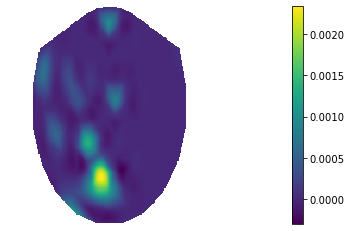

In [10]:
# Visualize the 204 * 1 weights for Imaginary Dataset
show_chanWeights(np.absolute(weights_img))

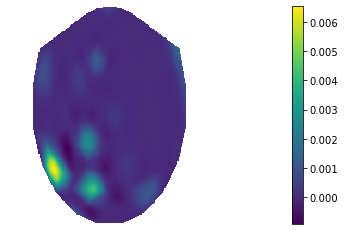

In [11]:
# Visualize the 204 * 1 weights for Overt Dataset
show_chanWeights(np.absolute(weights_overt))

In [12]:
def find_dominant (weights) :
    weights_abs = np.absolute(weights)
    indices = np.argpartition(weights_abs, -5)[-5:]
    do_channels = np.copy(indices[np.argsort(weights_abs[indices])])
    do_weights = weights[do_channels]
    return do_channels, do_weights

In [13]:
do_channels_img, do_weights_img = find_dominant(weights_img)
do_channels_overt, do_weights_overt = find_dominant(weights_overt)
print(do_channels_img.shape)
print(do_weights_img.shape)

(5,)
(5,)


In [14]:
for i in range(5) :
    print("Dominant Channel = %i, " % (do_channels_img[i]+1), "Dominant Weight = %.5f" % do_weights_img[i])

Dominant Channel = 137,  Dominant Weight = -0.00135
Dominant Channel = 122,  Dominant Weight = 0.00140
Dominant Channel = 188,  Dominant Weight = -0.00215
Dominant Channel = 153,  Dominant Weight = 0.00223
Dominant Channel = 154,  Dominant Weight = 0.00329


In [15]:
for i in range(5) :
    print("Dominant Channel = %i, " % (do_channels_overt[i]+1), "Dominant Weight = %.5f" % do_weights_overt[i])

Dominant Channel = 156,  Dominant Weight = -0.00245
Dominant Channel = 137,  Dominant Weight = -0.00265
Dominant Channel = 188,  Dominant Weight = -0.00302
Dominant Channel = 141,  Dominant Weight = 0.00421
Dominant Channel = 125,  Dominant Weight = 0.00632


In [16]:
def plot_weights_channels (weights, data_name) :
    figure, axis = plt.subplots()
    x_channels = np.linspace(1, 204, num = 204)
    axis.plot(x_channels, weights, linewidth = 1)
    axis.scatter(x_channels, weights, label = "Fold #1 Weights", linewidths = 3)
    
    do_channels, do_weights = find_dominant(weights)
    axis.scatter(do_channels, do_weights, label = "5 Dominant Channels and Weights", linewidths = 6, color = "red")
    do_info = [(do_channels[0], round(do_weights[0],5)), (do_channels[1], round(do_weights[1],5)), 
               (do_channels[2], round(do_weights[2],5)), (do_channels[3], round(do_weights[3],5)), 
               (do_channels[4], round(do_weights[4],5))]
    for i, each_info in enumerate(do_info) :
        axis.annotate(each_info, (do_channels[i], do_weights[i]), size = 14, ha = "center", va = "bottom")
    
    
    axis.set_xlabel("Weight Channel Number", fontsize = 15)
    axis.set_ylabel("Weight Value", fontsize = 15)
    axis.set_title("Show the Weight for Every Channel (" + data_name + " Movement)", fontsize = 15)
    #axis.grid()
    figure.set_size_inches(16, 7)
    x_axis = np.arange(1, 208, 10)
    x_axis[-1] = int(204)
    plt.xticks(x_axis, fontsize = 14)
    y_axis = np.linspace(np.min(weights), np.max(weights), num = 10)
    plt.yticks(y_axis, fontsize = 14)
    plt.legend(loc = "best", fontsize = 14)
    plt.show()
    return None

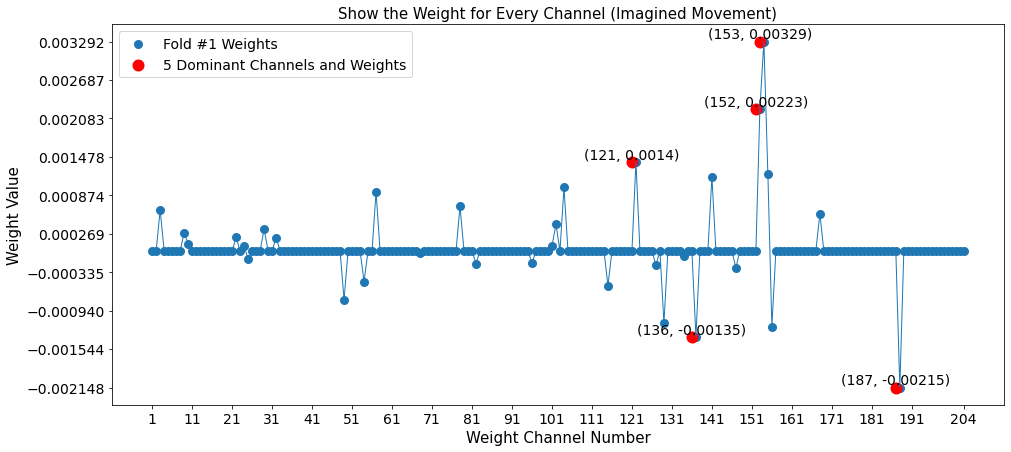

In [17]:
plot_weights_channels(weights_img, data_name = "Imagined")

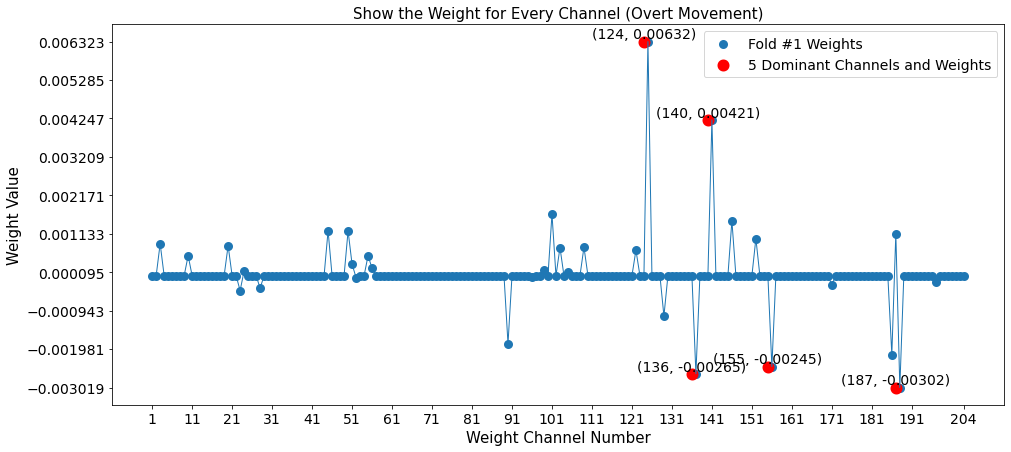

In [18]:
plot_weights_channels(weights_overt, data_name = "Overt")

In [19]:
def divide_labels (arr_data) :
    alldat = np.copy(arr_data)
    dat_zero = alldat[alldat[:,0]==(-1), :]
    dat_one = alldat[alldat[:,0]==1, :]
    return dat_zero, dat_one

def compute_PFA (H0, thres) :
    H0_ds = np.sort(H0[:, 1])
    false_alarm = float(len(H0_ds[H0_ds >= thres])) / (H0.shape[0])
    return false_alarm

def compute_PD (H1, thres) :
    H1_ds = np.sort(H1[:, 1])
    detection = float(len(H1_ds[H1_ds >= thres])) / (H1.shape[0])
    return detection

In [20]:
def flex_thresholds (arr_data, flex_type) :
    alldata = np.copy(arr_data)
    if flex_type == 1 :
        thres = np.zeros(2 + alldata.shape[0])
        thres[1:-1] = np.sort(alldata[:, 1])
        thres[0] = float("-inf")
        thres[-1] = float("inf")
    return thres

def compute_ROC (arr_data, flex_type = 1) :
    arr_thres = flex_thresholds(arr_data, flex_type = 1)
    arr_PD = np.zeros(len(arr_thres))
    arr_PFA = np.zeros(len(arr_thres))
    H0, H1 = divide_labels(arr_data)
    for i in range(len(arr_thres)) :
        arr_PD[i] = compute_PD(H1, arr_thres[i])
        arr_PFA[i] = compute_PFA(H0, arr_thres[i])
    return np.flipud(arr_PD), np.flipud(arr_PFA)

In [21]:
def plot_ROC (svm_ds, data_name) :
    y = np.zeros(40)
    y[0:20] = -1 
    y[20:40] = +1 
    total_cv_ds = svm_ds.flatten()
    total_cv_y = np.concatenate((y, y, y, y, y, y))
    arr_data1 = np.hstack((y.reshape(40, 1), svm_ds[0, :].reshape(40, 1)))
    arr_data2 = np.hstack((y.reshape(40, 1), svm_ds[1, :].reshape(40, 1)))
    arr_data3 = np.hstack((y.reshape(40, 1), svm_ds[2, :].reshape(40, 1)))
    arr_data4 = np.hstack((y.reshape(40, 1), svm_ds[3, :].reshape(40, 1)))
    arr_data5 = np.hstack((y.reshape(40, 1), svm_ds[4, :].reshape(40, 1)))
    arr_data6 = np.hstack((y.reshape(40, 1), svm_ds[5, :].reshape(40, 1)))
    arr_data7 = np.hstack((total_cv_y.reshape(240, 1), total_cv_ds.reshape(240, 1)))
    s1_pd, s1_pfa = compute_ROC(arr_data1)
    s2_pd, s2_pfa = compute_ROC(arr_data2)
    s3_pd, s3_pfa = compute_ROC(arr_data3)
    s4_pd, s4_pfa = compute_ROC(arr_data4)
    s5_pd, s5_pfa = compute_ROC(arr_data5)
    s6_pd, s6_pfa = compute_ROC(arr_data6)
    s7_pd, s7_pfa = compute_ROC(arr_data7)
    auc1 = metrics.auc(s1_pfa, s1_pd)
    auc2 = metrics.auc(s2_pfa, s2_pd)
    auc3 = metrics.auc(s3_pfa, s3_pd)
    auc4 = metrics.auc(s4_pfa, s4_pd)
    auc5 = metrics.auc(s5_pfa, s5_pd)
    auc6 = metrics.auc(s6_pfa, s6_pd)
    auc7 = metrics.auc(s7_pfa, s7_pd)
    refln = np.linspace(0, 1, num = 101)
    figure, axis = plt.subplots()
    axis.plot(s1_pfa, s1_pd, label = "Fold #1 (AUC = %.3f)" % auc1, linewidth = 12)
    axis.plot(s2_pfa, s2_pd, label = "Fold #2 (AUC = %.3f)" % auc2, linewidth = 10)
    axis.plot(s3_pfa, s3_pd, label = "Fold #3 (AUC = %.3f)" % auc3, linewidth = 9)
    axis.plot(s4_pfa, s4_pd, label = "Fold #4 (AUC = %.3f)" % auc4, linewidth = 8)
    axis.plot(s5_pfa, s5_pd, label = "Fold #5 (AUC = %.3f)" % auc5, linewidth = 7)
    axis.plot(s6_pfa, s6_pd, label = "Fold #6 (AUC = %.3f)" % auc6, linewidth = 6)
    axis.plot(s7_pfa, s7_pd, label = "Total CV (AUC = %.3f)" % auc7, linewidth = 6)
    axis.plot(refln, refln, "--", label = "Chance Diagonal", linewidth = 3)
    axis.set_xlabel("PFA", fontsize = 15)
    axis.set_ylabel("PD", fontsize = 15)
    axis.set_title("ROC Curve for " + data_name + " Movement", fontsize = 15)
    axis.grid()
    figure.set_size_inches(10, 7)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 14)
    plt.show()
    return None

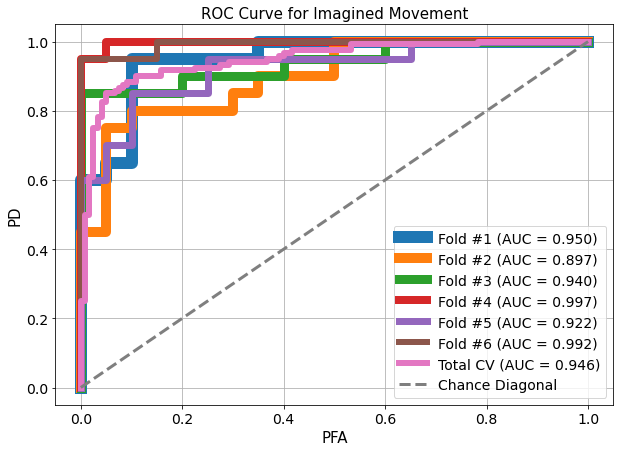

In [22]:
# Imaginary Dataset
# Provide the ROC for each 1st-level cross-validation fold (6 ROCs), 
# and the total cross-validated ROC on a single graph.
plot_ROC(ds_img, data_name = "Imagined")

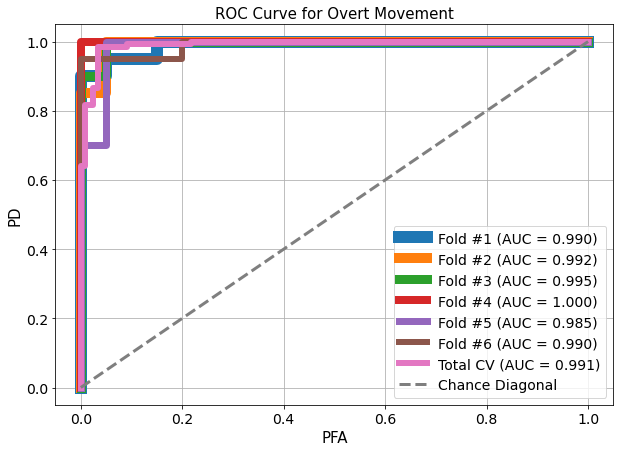

In [23]:
# Overt Dataset
# Provide the ROC for each 1st-level cross-validation fold (6 ROCs), 
# and the total cross-validated ROC on a single graph.
plot_ROC(ds_overt, data_name = "Overt")